In [118]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action="ignore")

In [119]:
RANDOM_STATE = 1
COLUMN_FOR_CLASSIFICATION = "koi_pdisposition"
CORRELATION_THRESHOLD = 0.9
TEST_SIZE = 0.4

In [120]:
df = pd.read_csv("./cumulative_2025.10.01_14.18.36.csv")
df.tail()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
9559,9560,10090151,K07985.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,-1.757,0.068,2.763,0.074,2.344,0.072,-1.756,0.068,2.929,0.072
9560,9561,10128825,K07986.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.497,0,...,-0.250,0.490,0.780,0.460,0.500,0.400,-0.180,0.470,0.530,0.470
9561,9562,10147276,K07987.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.021,0,...,-3.650,0.260,5.000,0.220,3.380,0.160,-3.890,0.260,5.160,0.220
9562,9563,10155286,K07988.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.092,0,...,1.320,0.670,1.690,0.530,1.450,0.110,1.370,0.660,2.000,0.460
9563,9564,10156110,K07989.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,3.300,1.100,3.400,1.100,0.960,0.670,3.400,1.100,3.500,1.100


In [121]:
df[COLUMN_FOR_CLASSIFICATION] = (
    df[COLUMN_FOR_CLASSIFICATION].astype("category").cat.codes
)
df[COLUMN_FOR_CLASSIFICATION].value_counts()

koi_pdisposition
1    4847
0    4717
Name: count, dtype: int64

In [122]:
# Remove all string columns
df = df.select_dtypes(include=[np.number])

# Remove all columns with null values
df = df.dropna(axis=1)

# Remove identifier columns
df = df.drop(columns=["rowid", "kepid"], axis=1)

In [123]:
corr_matrix = df.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
)
to_drop = [
    column
    for column in upper_triangle.columns
    if any(upper_triangle[column] > CORRELATION_THRESHOLD)
]
df.drop(to_drop, axis=1, inplace=True)

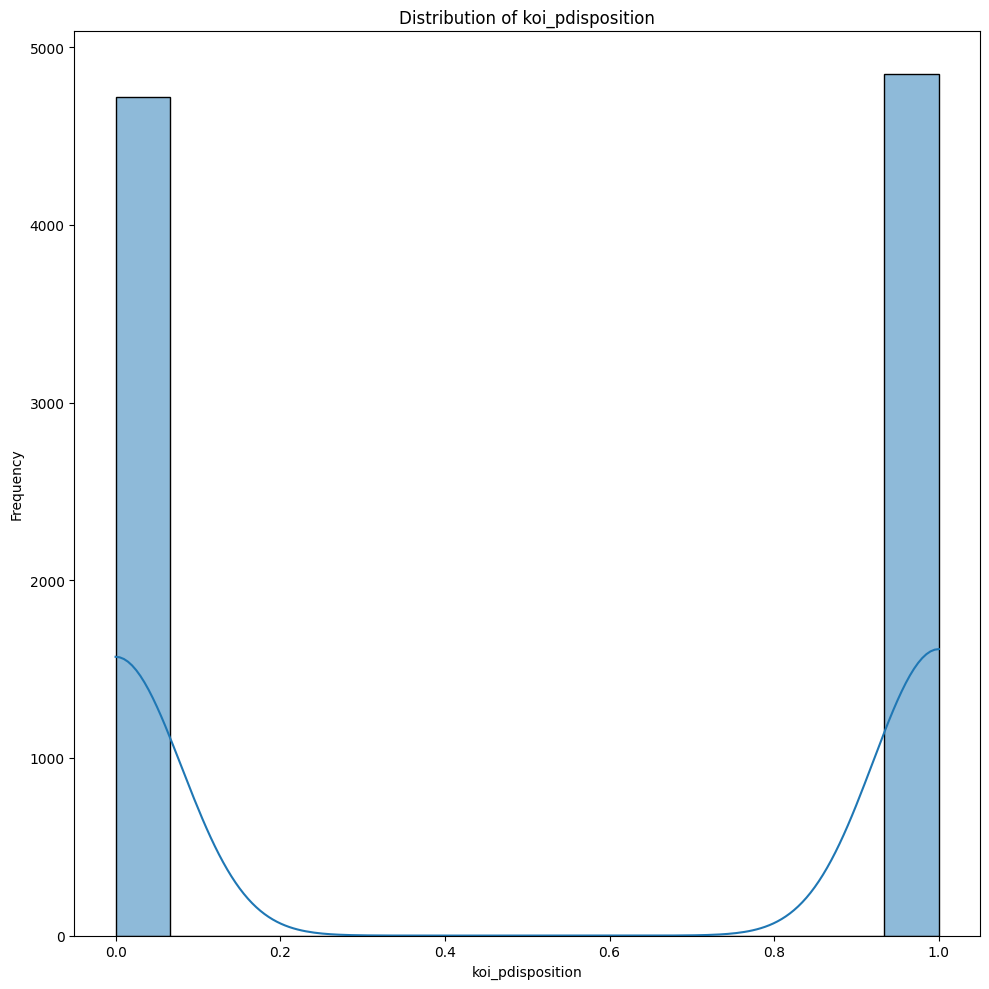

In [ ]:
def plot_distribution(df: pd.DataFrame, col: str):
    plt.figure(figsize=(10, 10))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


plot_distribution(df, COLUMN_FOR_CLASSIFICATION)

<Axes: >

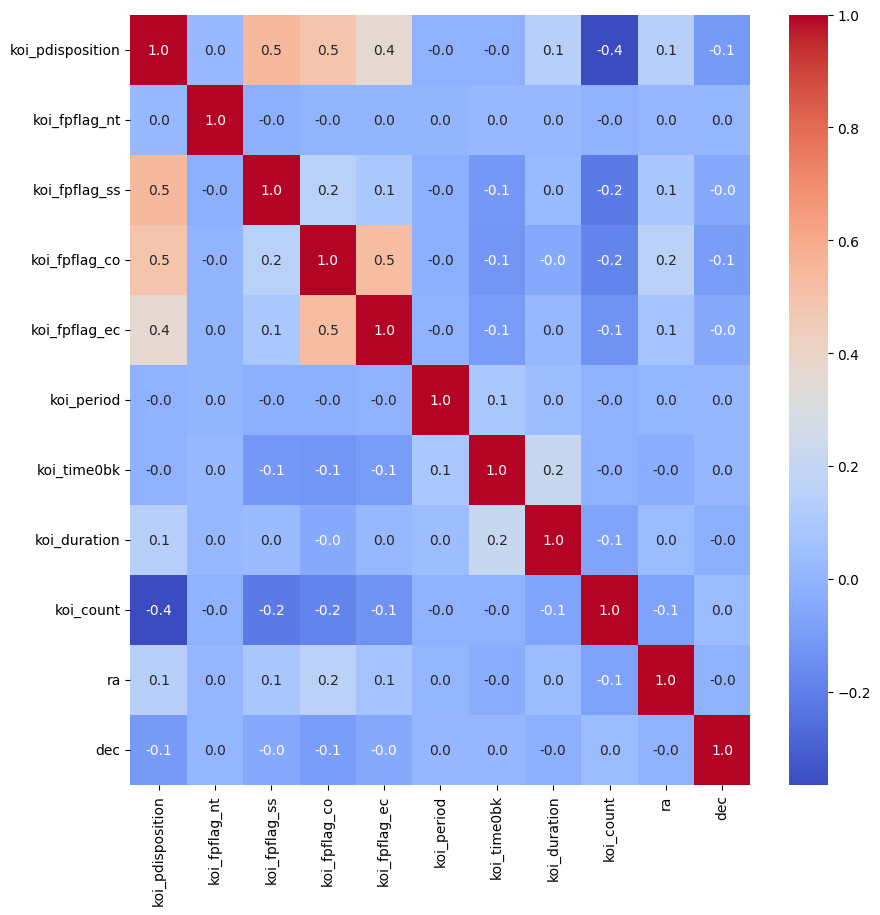

In [125]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".1f")

In [126]:
# Check if there are missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [127]:
y = df[COLUMN_FOR_CLASSIFICATION]
X = df.drop(columns=[COLUMN_FOR_CLASSIFICATION], axis=1)

In [128]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
X = pd.DataFrame(imputer.transform(X))

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X = pd.DataFrame(scaled_features)

In [129]:
# Split the resampled dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True, stratify=y
)

# Apply RandomOverSampler to balance the classes
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [130]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_clf.fit(X_train, y_train)

print(f"Training accuracy: {rf_clf.score(X_train, y_train) * 100:3.2f}%")
print(f"Testing accuracy: {rf_clf.score(X_test, y_test) * 100:3.2f}%")

Training accuracy: 100.00%
Testing accuracy: 98.72%


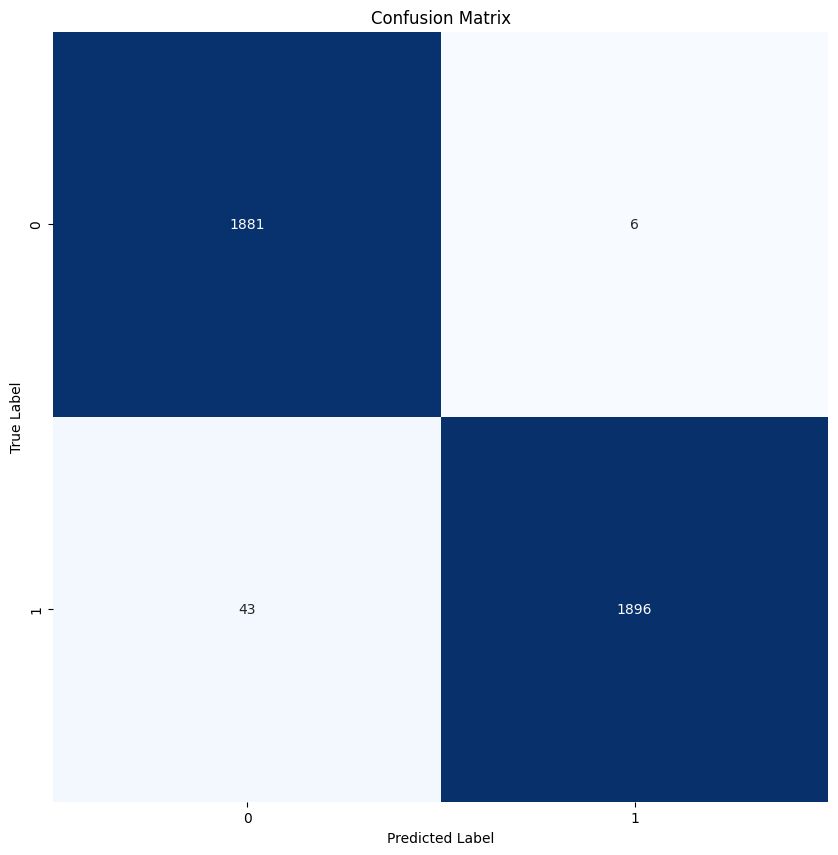

In [131]:
cf_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

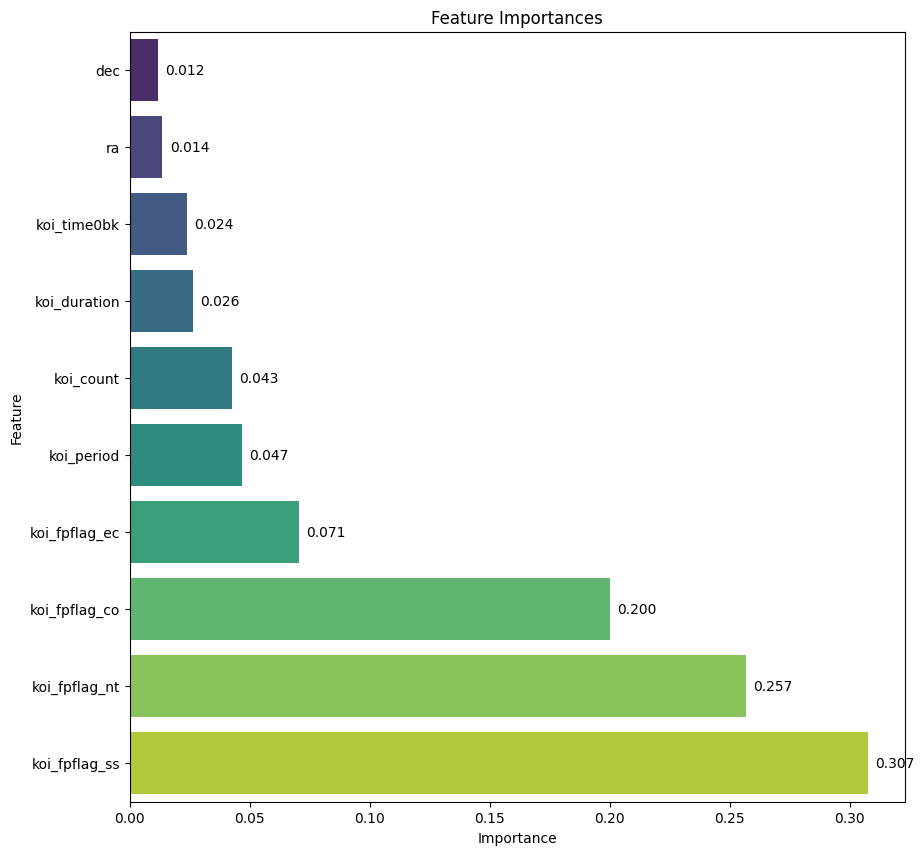

In [132]:
feature_names = df.drop(columns=[COLUMN_FOR_CLASSIFICATION]).columns.tolist()
importances = rf_clf.feature_importances_
feat_series = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 10))
ax = sns.barplot(x=feat_series.values, y=feat_series.index, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
for i, v in enumerate(feat_series.values):
    ax.text(v + max(feat_series.values) * 0.01, i, f"{v:.3f}", va="center")

plt.show()